In [26]:
import pandas as pd
import numpy as np
import os
import PyPDF2 as pypdf
import docx
from matplotlib import pyplot as plt
from transformers import GPT2TokenizerFast, GPT2Model
import torch
from datasets import Dataset
from tqdm import tqdm
from sklearn.manifold import TSNE

### Data Preprocessing

#### Tasks are:
- convert all documents to .txt format
- get at least one response from chatGPT for your prompt and save it as a txt file.
- where possible (data we know was/wasn't generated by a LM), tag with label (0 for human, 1 for LLM)
- output should be a dictionary with all relevant files labeled as 
{
"label": 0,
"text": "blahblahblahblahblah I did something on this assignment"
}

#### You'll need to have poppler installed and then pdftotext too.
- see here: https://github.com/jalan/pdftotext


In [209]:
pwd = os.getcwd()
folder_name = 'S23MHAS/' # call this what you want
# quick check to make sure the data folder exists.
# once it does exist, drop your raw data from student submissions into submissions_raw
if not os.path.exists(pwd+'/data/'+folder_name):
    os.mkdir(pwd+'/data/'+folder_name)
    os.mkdir(pwd+'/data/'+folder_name+'submissions_raw_human/')
    os.mkdir(pwd+'/data/'+folder_name+'submissions_clean_human/')
    os.mkdir(pwd+'/data/'+folder_name+'submissions_raw_LM/')
    os.mkdir(pwd+'/data/'+folder_name+'submissions_clean_LM/')
os.path.exists(pwd+'/data/'+folder_name+'submissions_raw_human/')

True

In [211]:
# functions to clean pdf and docx files (two most common submission types)
def clean_pdf(file_path_in, file_path_out):
    raw_subs = os.listdir(file_path_in)
    files = [file for file in raw_subs if file[-3:]=='pdf']
    for file in files:
        pf = open(file_path_in+file,'rb')
        pagelen = len(pypdf.PdfReader(pf).pages)
        ptext = [pypdf.PdfReader(pf).pages[item].extract_text() for item in range(pagelen)]
        outtext = ' '.join(ptext)
        with open(file_path_out+file+'.txt', 'w') as f:
            f.write(outtext)
    print("processed all pdf files")

def clean_docx(file_path_in, file_path_out):
    raw_subs = os.listdir(file_path_in)
    files = [file for file in raw_subs if file[-4:]=='docx']
    for file in files:
        doc = docx.Document(file_path_in+file)
        dtext = [para.text for para in doc.paragraphs]
        outtext = ' '.join(dtext)
        with open(file_path_out+file+'.txt', 'w') as f:
            f.write(outtext)
    print("processed all docx files")

def clean_html(file_path_in, file_path_out):
    from bs4 import BeautifulSoup
    raw_subs = os.listdir(file_path_in)
    files = [file for file in raw_subs if file[-4:]=='html']
    for file in files:
        with open(file_path_in+file, 'r') as f:
            contents = f.read()
            soup = BeautifulSoup(contents,'lxml')
            outtext = soup.get_text().replace('\n',' ')
            with open(file_path_out+file+'.txt', 'w') as ff:
                ff.write(outtext)
                ff.close()
            f.close()
    print("processed all html files")

# read the files in to a pandas series
def read_text_response(file):
    with open(file, 'rb') as f:
        outert = f.read()
        f.close()
    return outert

# eigenvalue calculations
def eigvals(matrix_in):
    ow, ov = np.linalg.eig(matrix_in)
    return np.sort(ow)
    

In [212]:
raw_data_path = pwd+'/data/'+folder_name+'submissions_raw_human/'
clean_data_path = pwd+'/data/'+folder_name+'submissions_clean_human/'

clean_pdf(raw_data_path, clean_data_path)
clean_docx(raw_data_path, clean_data_path)
clean_html(raw_data_path, clean_data_path)

processed all pdf files
processed all docx files
processed all html files


In [257]:
human_text = pd.Series([read_text_response(clean_data_path+file) for file in os.listdir(clean_data_path)])
human_files = pd.Series(os.listdir(clean_data_path))

(array([20., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 245. ,  499.1,  753.2, 1007.3, 1261.4, 1515.5, 1769.6, 2023.7,
        2277.8, 2531.9, 2786. ]),
 <BarContainer object of 10 artists>)

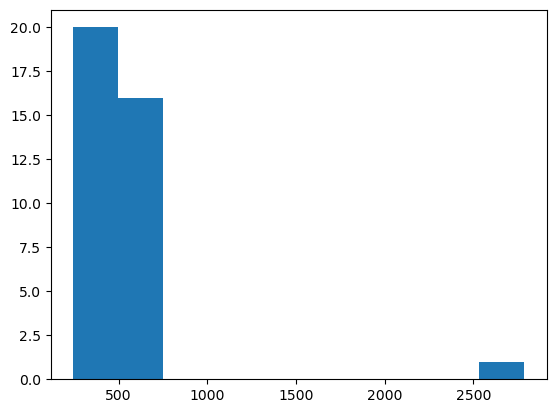

In [258]:
lnz = [len(item.split()) for item in human_text]
plt.hist(lnz)

In [261]:
# making a dataframe of human answers
labels = [0 for item in human_text]
df_human = pd.DataFrame({'label':labels, 'text':human_text, 'file':human_files})
df_human.shape

(37, 3)

### ChatGPT answer time: Go put your prompt into ChatGPT and save the answer in a txt file.

In [263]:
chatGPT_filename = 'chatGPT_inforisks.txt'
chatGPT_text = [read_text_response(os.getcwd()+'/data/'+folder_name+'submissions_clean_LM/'+chatGPT_filename)]
gpt_labels = [1 for item in chatGPT_text]
df_gpt = pd.DataFrame({'label':gpt_labels, 'text':chatGPT_text, 'file':chatGPT_filename})
len(df_gpt.text[0].split())

266

In [264]:
df_human.shape

(37, 3)

In [265]:
input_text = pd.concat([df_human, df_gpt], axis=0, ignore_index=True)

### Tokenizer
- Okay now we have a dataframe with everyone's answers in it. Let's tokenize that.
- In tokenizing we have to select a language model. Let's do something small and easy.
- Once the tokenizer is done, we'll use the language model to output a matrix of embeddings for each response.

In [218]:
# let's try GPT2
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
model = GPT2Model.from_pretrained('gpt2')

In [266]:
input_text["text"] = input_text["text"].astype(str)

In [267]:
# for later if I feel like optimizing stuff. still run this but you can mostly ignore the output.
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, return_tensors="pt")

input_text_dataset = Dataset.from_pandas(input_text)
tokenized_resp = input_text_dataset.map(preprocess_function)

  0%|          | 0/38 [00:00<?, ?ex/s]

### Model output!
- What does this do? It outputs a L x 768 tensor for each response.
- With these values we can tell how similar everything is to the ChatGPT response in the last row.
- We'll do this similar scoring with very simple matrix algebra, with the added bonus that we can compare student similarities

In [227]:
outputs = []
with torch.no_grad():
    for resp in tqdm(input_text['text']):
        inputs = tokenizer(resp, return_tensors='pt', truncation=True)
        gpt2_outputs = model(**inputs)
        outputs.append(gpt2_outputs.last_hidden_state.squeeze())

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:26<00:00,  1.41it/s]


#### The following two items should be pretty much the same. They're both chatGPT.

In [232]:
list(input_text['text'])[-1]

"b'Some tools that major digital companies use to mitigate moral hazard include:\\nPerformance-based compensation: linking pay to specific performance metrics to align the interests of employees with those of the company\\nMonitoring and surveillance: using technology to track employee activity and ensure they are working on the tasks they are supposed to be working on\\nIncentive alignment: designing tasks and projects in a way that incentivizes employees to work efficiently and effectively\\nMulti-tasking constraints: limiting the number of tasks an employee can work on at one time to reduce the potential for shirking\\nIn designing an employment contract for workers where it is difficult to measure effort, one approach would be to use a piece rate system, where pay is based on the number of units of output produced. This aligns the incentives of the worker with those of the employer, as the worker has an incentive to produce as much output as possible. Another approach is to use con

In [238]:
df_gpt.text[0]

b'Some tools that major digital companies use to mitigate moral hazard include:\nPerformance-based compensation: linking pay to specific performance metrics to align the interests of employees with those of the company\nMonitoring and surveillance: using technology to track employee activity and ensure they are working on the tasks they are supposed to be working on\nIncentive alignment: designing tasks and projects in a way that incentivizes employees to work efficiently and effectively\nMulti-tasking constraints: limiting the number of tasks an employee can work on at one time to reduce the potential for shirking\nIn designing an employment contract for workers where it is difficult to measure effort, one approach would be to use a piece rate system, where pay is based on the number of units of output produced. This aligns the incentives of the worker with those of the employer, as the worker has an incentive to produce as much output as possible. Another approach is to use contracts

In [280]:
# pull a human response
list(input_text['text'])[13]

In [240]:
outputs[-1].shape, len(tokenized_resp['text'][-1].split())

(torch.Size([343, 768]), 252)

In [241]:
# calculate the mean values of the responses so each response is a vector (makes life easier)
np_outputs = [tens.numpy() for tens in outputs]
# now we want them all to be the same size so we do A'A. This will get us a 768x768 matrix.
matrix_outputs = [A.T.dot(A) for A in np_outputs]

#### okay above now we have the 768x768 values per student response. We can calculate the pairwise similarities to ChatGPT.

In [138]:
(matrix_outputs[0] - matrix_outputs[-1]).shape

(768, 768)

In [242]:
np.linalg.norm(matrix_outputs[0]-matrix_outputs[-1], ord='fro')

32497650.0

seems like the tests work and some kind of reasonable number is popping out. okay let's compare to chatGPT!

In [268]:
chatGPT_matrix = matrix_outputs[-1]
# calculate frobenius norm as measure of matrix distance. arbitrary choice tbh.
frob_norm = [np.linalg.norm(A - chatGPT_matrix, ord='fro') for A in matrix_outputs]

# z-score of frob_norm
frob_norm_z = (frob_norm - np.mean(frob_norm))/np.std(frob_norm)
tuple(zip(frob_norm, frob_norm_z))

((32497650.0, 0.8523099),
 (21764820.0, 0.11170449),
 (37623430.0, 1.206008),
 (66804530.0, 3.2196128),
 (31625888.0, 0.792155),
 (3174911.2, -1.1710687),
 (20393964.0, 0.017110305),
 (19882846.0, -0.018158747),
 (19304440.0, -0.05807092),
 (16408120.0, -0.25792783),
 (42380940.0, 1.5342938),
 (7414433.5, -0.87852573),
 (17536440.0, -0.18006952),
 (1375318.9, -1.2952473),
 (22980568.0, 0.19559564),
 (39564496.0, 1.3399487),
 (1734737.0, -1.270446),
 (3189437.8, -1.1700662),
 (27423508.0, 0.5021751),
 (4741178.0, -1.0629904),
 (7340433.5, -0.883632),
 (14989813.0, -0.3557963),
 (9031154.0, -0.76696604),
 (26938182.0, 0.4686858),
 (28934728.0, 0.6064549),
 (34139920.0, 0.9656326),
 (33406312.0, 0.9150109),
 (3559586.2, -1.1445247),
 (25757752.0, 0.3872317),
 (24219406.0, 0.2810801),
 (6744010.5, -0.9247875),
 (30759532.0, 0.73237324),
 (5111674.5, -1.0374248),
 (13338035.0, -0.46977517),
 (10385483.0, -0.6735123),
 (39007180.0, 1.3014917),
 (14063257.0, -0.41973212),
 (0.0, -1.3901494))

(array([0.45669667, 0.34252255, 0.3425225 , 0.28543544, 0.34252253,
        0.28543542, 0.05708708, 0.        , 0.        , 0.0570871 ]),
 array([-1.39014935, -0.92917311, -0.46819693, -0.0072207 ,  0.45375553,
         0.91473174,  1.37570798,  1.83668423,  2.29766035,  2.75863671,
         3.21961284]),
 <BarContainer object of 10 artists>)

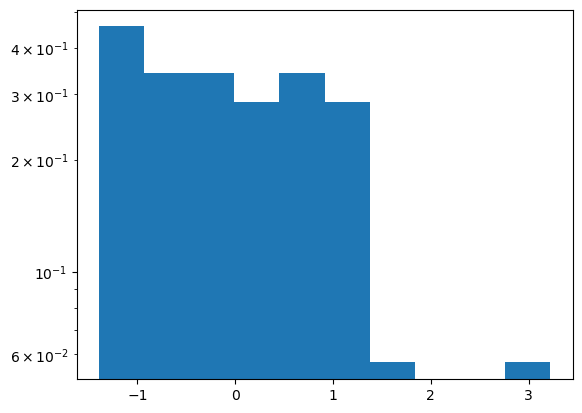

In [244]:
plt.hist((frob_norm - np.mean(frob_norm))/np.std(frob_norm), log=True, density=True)

In [246]:
chatgpt_eig = eigvals(chatGPT_matrix)

In [247]:
eig = [eigvals(A) for A in matrix_outputs]
two_eig = [item[-2:] for item in eig]

In [248]:
two_eig

[array([  984039.4, 52685008. ], dtype=float32),
 array([  430832.1, 41940920. ], dtype=float32),
 array([  751279.25, 57779740.  ], dtype=float32),
 array([  265800.34, 86817952.  ], dtype=float32),
 array([  965758., 51859164.], dtype=float32),
 array([  570358.25, 23120826.  ], dtype=float32),
 array([  939925.8, 40580592. ], dtype=float32),
 array([  330373.88, 39999556.  ], dtype=float32),
 array([  666910.06, 39496496.  ], dtype=float32),
 array([  489456.25, 36594304.  ], dtype=float32),
 array([ 1364738.9, 62559488. ], dtype=float32),
 array([  587908.5, 27585868. ], dtype=float32),
 array([  363394.75, 37690364.  ], dtype=float32),
 array([  268805.2, 19868912. ], dtype=float32),
 array([  391706.56, 43147344.  ], dtype=float32),
 array([ 1631760.6, 59724412. ], dtype=float32),
 array([  251918.69, 20460556.  ], dtype=float32),
 array([  210427.9, 23212878. ], dtype=float32),
 array([  668781.5, 47586912. ], dtype=float32),
 array([  355498.56, 24915344.  ], dtype=float32),
 a

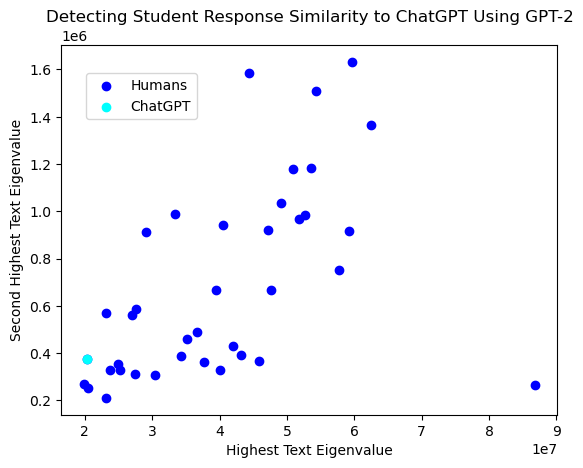

In [278]:
arrayone = [item[0] for item in two_eig]
arraytwo = [item[1] for item in two_eig]
plt.scatter(arraytwo, arrayone, c='b')
plt.scatter(arraytwo[-1],arrayone[-1],c='cyan')
plt.title("Detecting Student Response Similarity to ChatGPT Using GPT-2")
plt.xlabel("Highest Text Eigenvalue")
plt.ylabel("Second Highest Text Eigenvalue")
plt.legend(['Humans','ChatGPT'], loc=(0.05,0.8))

In [250]:
eigmatrix = np.vstack([thing[-20:] for thing in eig])
eigmatrix.shape

(38, 20)

In [251]:
eigmatrix

array([[1.76322498e+03, 2.07192114e+03, 2.15180322e+03, 2.26231323e+03,
        2.33071045e+03, 2.58997974e+03, 2.82453955e+03, 3.03017969e+03,
        3.58204663e+03, 4.75741211e+03, 8.54642188e+03, 1.20755703e+04,
        1.74230820e+04, 2.31239219e+04, 3.28324023e+04, 4.94137344e+04,
        1.49145625e+05, 2.79859344e+05, 9.84039375e+05, 5.26850080e+07],
       [1.89898730e+03, 1.91247546e+03, 2.04162842e+03, 2.17692651e+03,
        2.51018384e+03, 2.80756323e+03, 2.89525098e+03, 3.20500195e+03,
        3.51439819e+03, 6.29830664e+03, 7.76993018e+03, 9.01690723e+03,
        1.10819092e+04, 2.63066777e+04, 3.09449805e+04, 4.84810352e+04,
        6.83065781e+04, 2.92870312e+05, 4.30832094e+05, 4.19409200e+07],
       [2.05837109e+03, 2.20096777e+03, 2.47717261e+03, 2.79609229e+03,
        2.95783398e+03, 3.03471167e+03, 3.46042529e+03, 3.69982471e+03,
        4.58729639e+03, 7.12073926e+03, 9.53402148e+03, 1.14834502e+04,
        1.43054912e+04, 3.34033164e+04, 3.89722461e+04, 5.7860

In [253]:
eig_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(np.vstack(eig))

In [254]:
eig_embedded

array([[ 2.66882172e+01,  1.36838675e+01],
       [ 5.09279156e+00,  8.14935970e+00],
       [ 3.52060318e+01,  1.38564024e+01],
       [ 4.22567444e+01,  1.52787790e+01],
       [ 2.55128040e+01,  1.14013596e+01],
       [-3.17775955e+01, -1.92468262e+01],
       [ 2.81894946e+00,  6.26454926e+00],
       [ 8.38097930e-01,  7.78573561e+00],
       [ 3.58548053e-02,  5.49937963e+00],
       [-5.56770134e+00,  3.10292912e+00],
       [ 3.98031044e+01,  1.35800238e+01],
       [-2.11300125e+01, -1.01919527e+01],
       [-3.49444485e+00,  4.39878845e+00],
       [-3.55609322e+01, -2.49990959e+01],
       [ 7.58546543e+00,  8.85160923e+00],
       [ 3.75730286e+01,  1.50024176e+01],
       [-3.33533211e+01, -2.39149837e+01],
       [-2.95927792e+01, -2.01179161e+01],
       [ 1.64839821e+01,  1.20145578e+01],
       [-2.71493988e+01, -1.65955124e+01],
       [-2.31986046e+01, -8.91843700e+00],
       [-8.21513557e+00,  2.58625650e+00],
       [-1.99895020e+01, -7.36782408e+00],
       [ 1.

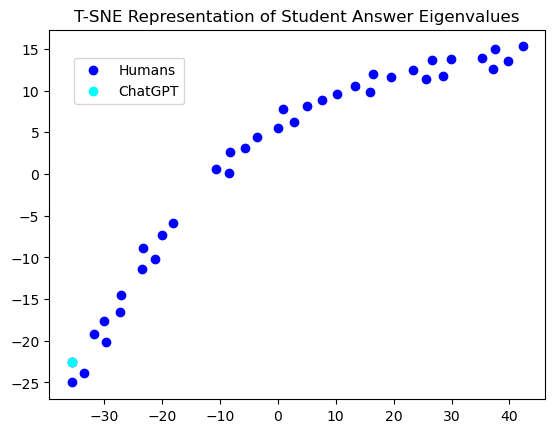

In [255]:
plt.scatter([thing[0] for thing in eig_embedded], [thing[1] for thing in eig_embedded], c='b')
plt.scatter(eig_embedded[-1][0], eig_embedded[-1][1], c='cyan')
plt.title('T-SNE Representation of Student Answer Eigenvalues')
plt.legend(['Humans','ChatGPT'], loc=(0.05,0.8))

### okay which files had the closest similarity to chatGPT?

In [282]:
check_df = pd.DataFrame(
    {'file':input_text['file'], 
     'frob_norm':pd.Series(frob_norm), 
     'frob_norm_z':pd.Series(frob_norm_z)}
)

# uncomment the below and you can run the cell (I'm hiding my students' responses)
check_df

In [281]:
check_df.sort_values(by='frob_norm_z', ascending=True)